## 使用SageMaker+XGBoost，将时间序列转换为监督学习，完成预测性维护的实践
https://github.com/liangyimingcom/Use-SageMaker_XGBoost-convert-Time-Series-into-Supervised-Learning-for-predictive-maintenance
**关键字**：SageMaker；XGBoost；Python；滑窗；滑动窗口方法；时间序列预测转化为监督学习问题；将多元时间序列数据转换为监督学习问题；如何用Python将时间序列问题转化为有监督学习问题；时间序列预测的机器学习模型；Machine Learning；ML；

# Step4: [补充内容] 准备用于训练的数据集，完成数据预处理与特征工程：

### 本章节内容Contents  
   - [ ] 1）探索相关性；
   - [ ] 2）缩小特征值范围；
   - [ ] 3）确认数据集从282列缩减为58个列
   

In [10]:
#使用 pandas 库加载和显示此原始数据集。 生成的 `df` 变量是 pandas [DataFrame]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
#from xgboost import XGBRegressor
%matplotlib inline
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

import os
from datetime import datetime
from time import gmtime, strftime, sleep

### 使用dataframe load原始数据集，并进行初步的处理


In [11]:
## load csv path
csv_path = './yiming-arraged/10000871-part_ac-part1.csv'
df = pd.read_csv(csv_path,low_memory=False)
#df.describe()

#数据清理： 按照时间排序数组后，然后删除时间的属性
df = df.drop(['MAC', 'SYSTEM_IMEI', 'name', 'TYPEID', 'createTime', 'topic', 'shutTime', 'TIME (2)'], axis=1)
df['time']=pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)
df = df.drop(['time'], axis=1)

#数据清理: 转化 code 到 hascode = true/false 
# 根据hascode属性的请看，添加Ishascode =true/false 的列
df['hascode'] = (np.where(df['code'].isnull().values, False, True)).astype(object)
df = df.drop(['code'], axis=1)
df = df.fillna(0)
#for testig
#df = df.head(10000)

df.describe()

,1S0Z7F92N86S68KI_10_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_10_COMPCURRENT,1S0Z7F92N86S68KI_10_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_10_COMPLOAD,1S0Z7F92N86S68KI_10_COMPPOWER,1S0Z7F92N86S68KI_10_COMPRUNTIME,1S0Z7F92N86S68KI_10_COMPSPEED,1S0Z7F92N86S68KI_10_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_10_COMPVOLTAGE,1S0Z7F92N86S68KI_10_CONDSIDEEXHAUSTPRESS,...,SYSTEM_SELECTINOUT,SYSTEM_SELECTREFRHEAT,SYSTEM_SYSFAILURE,SYSTEM_UNITFAILURE,SYSTEM_UNITPOWER,SYSTEM_UNITRATEDFULLLOAD,SYSTEM_UNITRUNFEEDBACK,SYSTEM_UNITSTOPFEEDBACK,SYSTEM_VERSION40000,SYSTEM_VERSION40001
count,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.000000,99999.0,99999.0,99999.0,99999.000000,99999.0,99999.000000,99999.000000,99999.0,99999.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.816108,0.0,0.0,0.0,10.272266,0.0,0.218502,0.597606,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.387398,0.0,0.0,0.0,30.024056,0.0,0.413232,0.490383,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,181.300000,0.0,1.000000,1.000000,0.0,0.0


我们来深入了解一下。按照现代标准，这是一个相对较大的数据集，有 130W 条记录。
每条记录使用 超过282个属性来描述设备信息。
这些属性如下：
- `name`： 设备名称
- `time`： 设备timestamp（时间打点）
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- `无法公开`：无法公开
- ....
- `code?`：设备故障代码（分类，代表不同的报警类型）

最后一个属性 `code?` 称为*目标属性*，即我们希望 ML 模型预测的属性。

#### 开始探索数据以及属性之间的关系并使其实现可视化，用直方图来查看各个属性的值的分布情况，并计算出值属性的汇总统计数据，如均值、最小值、最大值、标准差等。 
对于类别变量，我们需要查看频率表。更为直观的方法是为每个数值特征构建直方图；

In [12]:
# 显示汇总统计数据
display(df.describe())

,1S0Z7F92N86S68KI_10_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_10_COMPCURRENT,1S0Z7F92N86S68KI_10_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_10_COMPLOAD,1S0Z7F92N86S68KI_10_COMPPOWER,1S0Z7F92N86S68KI_10_COMPRUNTIME,1S0Z7F92N86S68KI_10_COMPSPEED,1S0Z7F92N86S68KI_10_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_10_COMPVOLTAGE,1S0Z7F92N86S68KI_10_CONDSIDEEXHAUSTPRESS,...,SYSTEM_SELECTINOUT,SYSTEM_SELECTREFRHEAT,SYSTEM_SYSFAILURE,SYSTEM_UNITFAILURE,SYSTEM_UNITPOWER,SYSTEM_UNITRATEDFULLLOAD,SYSTEM_UNITRUNFEEDBACK,SYSTEM_UNITSTOPFEEDBACK,SYSTEM_VERSION40000,SYSTEM_VERSION40001
count,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,99999.0,...,99999.000000,99999.0,99999.0,99999.0,99999.000000,99999.0,99999.000000,99999.000000,99999.0,99999.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.816108,0.0,0.0,0.0,10.272266,0.0,0.218502,0.597606,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.387398,0.0,0.0,0.0,30.024056,0.0,0.413232,0.490383,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,0.0,0.0,0.0,181.300000,0.0,1.000000,1.000000,0.0,0.0


### 相关性探索：对设备不同属性之间的成对关系探索，了解它们之间的关系

#### 【请注意】在海量数据下与原始列的情况下，使用pandas函数 corr() 和 scatter_matrix()反复画图验证，锁定了以下属性之间具体相关性。方法如下，但是中间反复尝试的的裁剪过程被省略。
函数参考：https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.plotting.scatter_matrix.html

#### (1)设备主信息 - 相关性探索后，缩小的特征值范围
字段有：'SYSTEM_CONDCAPACITY',
'SYSTEM_CONDSIDETEMPIN',
'SYSTEM_CONDSIDETEMPOUT',
'SYSTEM_EVAPCAPACITY',
'SYSTEM_EVAPSIDETEMPOUT',
'SYSTEM_UNITPOWER'

,SYSTEM_CONDCAPACITY,SYSTEM_CONDSIDETEMPIN,SYSTEM_CONDSIDETEMPOUT,SYSTEM_EVAPCAPACITY,SYSTEM_EVAPSIDETEMPOUT,SYSTEM_UNITPOWER
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,83.126596,25.914375,26.533561,91.582866,10.763398,10.272266
std,278.379249,3.342158,3.698556,302.363581,1.771161,30.024056
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.400000,25.500000,0.000000,9.800000,0.000000
50%,0.000000,26.300000,26.800000,0.000000,10.600000,0.000000
75%,0.000000,27.200000,28.000000,0.000000,11.800000,0.000000
max,1716.590000,30.500000,33.000000,1907.320000,18.000000,181.300000


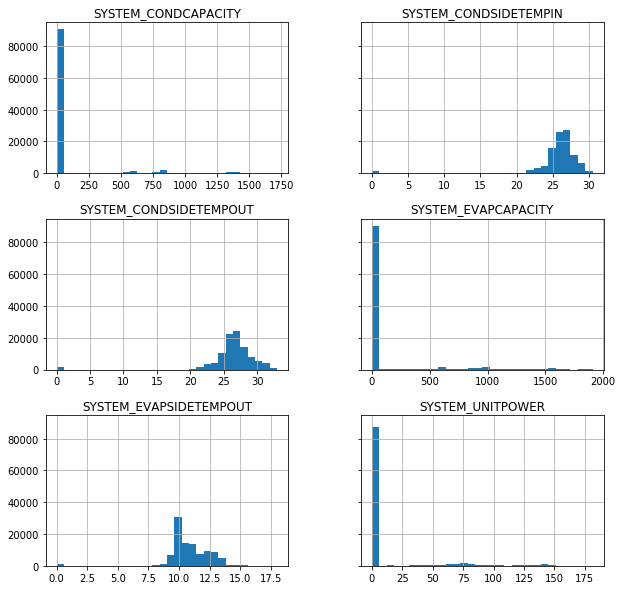

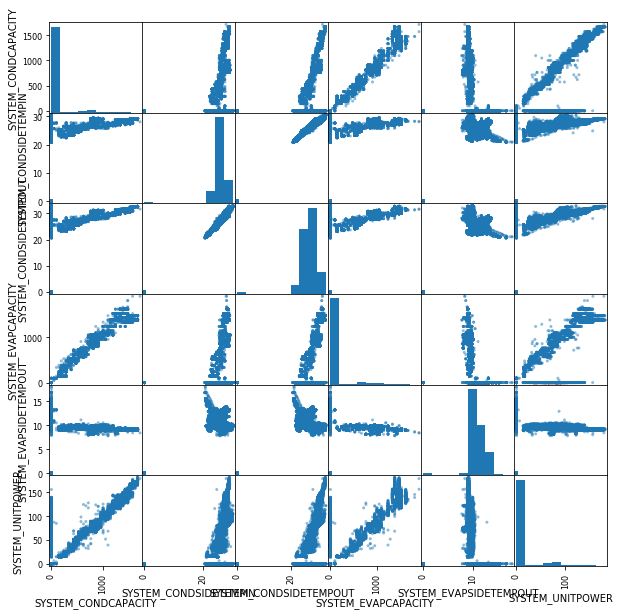

In [13]:
#设备主信息
df_scatter_base = df[[
'SYSTEM_CONDCAPACITY',
'SYSTEM_CONDSIDETEMPIN',
'SYSTEM_CONDSIDETEMPOUT',
'SYSTEM_EVAPCAPACITY',
'SYSTEM_EVAPSIDETEMPOUT',
'SYSTEM_UNITPOWER'
]]

# 显示汇总统计数据
display(df_scatter_base.describe())

# 为每个数值特征构建直方图
%matplotlib inline
hist = df_scatter_base.hist(bins=30, sharey=True, figsize=(10, 10))

#探索属性之间的成对关系，以了解它们之间的关系
pd.plotting.scatter_matrix(df_scatter_base,  figsize=(10, 10))
plt.show()

#### (2)第一个设备子机 - 相关性探索后，缩小的特征值范围
字段有：'1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_1_COMPCURRENT',
'1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_1_COMPLOAD',
'1S0Z7F92N86S68KI_1_COMPPOWER',
'1S0Z7F92N86S68KI_1_COMPRUNTIME',
'1S0Z7F92N86S68KI_1_COMPSPEED',
'1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_1_COMPVOLTAGE',
'1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_1_ECONPRESS',
'1S0Z7F92N86S68KI_1_ECONREFRTEMP',
'1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_1_INVERTERTEMP',
'1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_1_MAINLOOPLEVEL',

,1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_1_COMPCURRENT,1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_1_COMPLOAD,1S0Z7F92N86S68KI_1_COMPPOWER,1S0Z7F92N86S68KI_1_COMPRUNTIME,1S0Z7F92N86S68KI_1_COMPSPEED,1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_1_COMPVOLTAGE,1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS,1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT,1S0Z7F92N86S68KI_1_ECONPRESS,1S0Z7F92N86S68KI_1_ECONREFRTEMP,1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS,1S0Z7F92N86S68KI_1_INVERTERTEMP,1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING,1S0Z7F92N86S68KI_1_MAINLOOPLEVEL
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000
mean,14.356480,15.339733,31.343586,3.109415,3.083442,4557.135241,4336.960330,23.722813,394.965420,585.033025,272.979835,-101.255428,-61.434519,334.947784,0.0,2.372005,52.629396
std,34.821872,30.340788,4.342206,11.348878,11.328603,106.442078,8419.488886,10.344627,14.414436,55.106450,5.727391,2.124440,1.290552,51.509250,0.0,8.756429,5.505933
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-101.300000,-61.800000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,28.100000,0.000000,0.000000,4538.000000,0.000000,25.300000,385.000000,550.900000,273.100000,-101.300000,-61.500000,335.500000,0.0,0.000000,53.000000
50%,0.000000,0.000000,30.000000,0.000000,0.000000,4586.000000,0.000000,27.600000,399.000000,575.100000,273.100000,-101.300000,-61.500000,353.400000,0.0,0.000000,53.000000
75%,0.000000,0.000000,34.600000,0.000000,0.000000,4586.000000,0.000000,29.800000,403.000000,608.700000,273.100000,-101.300000,-61.400000,366.700000,0.0,0.000000,53.000000
max,102.000000,123.000000,42.100000,65.000000,72.000000,4631.000000,23637.000000,37.100000,431.000000,756.700000,273.100000,0.000000,0.000000,458.400000,0.0,96.800000,74.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


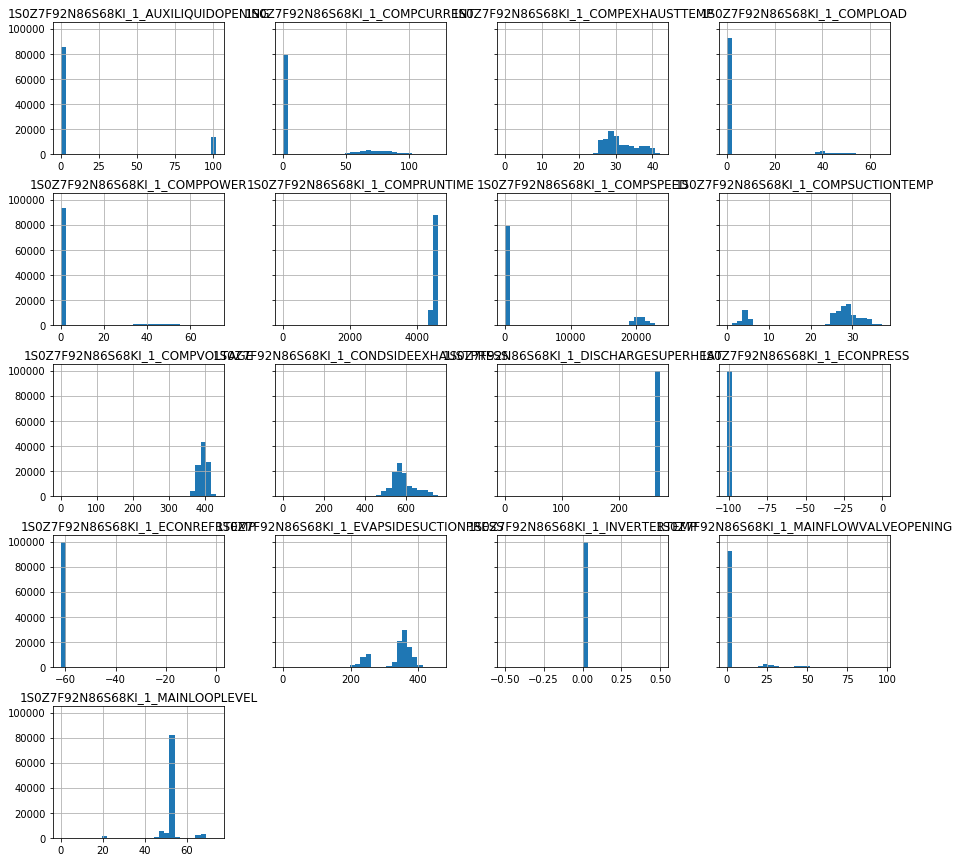

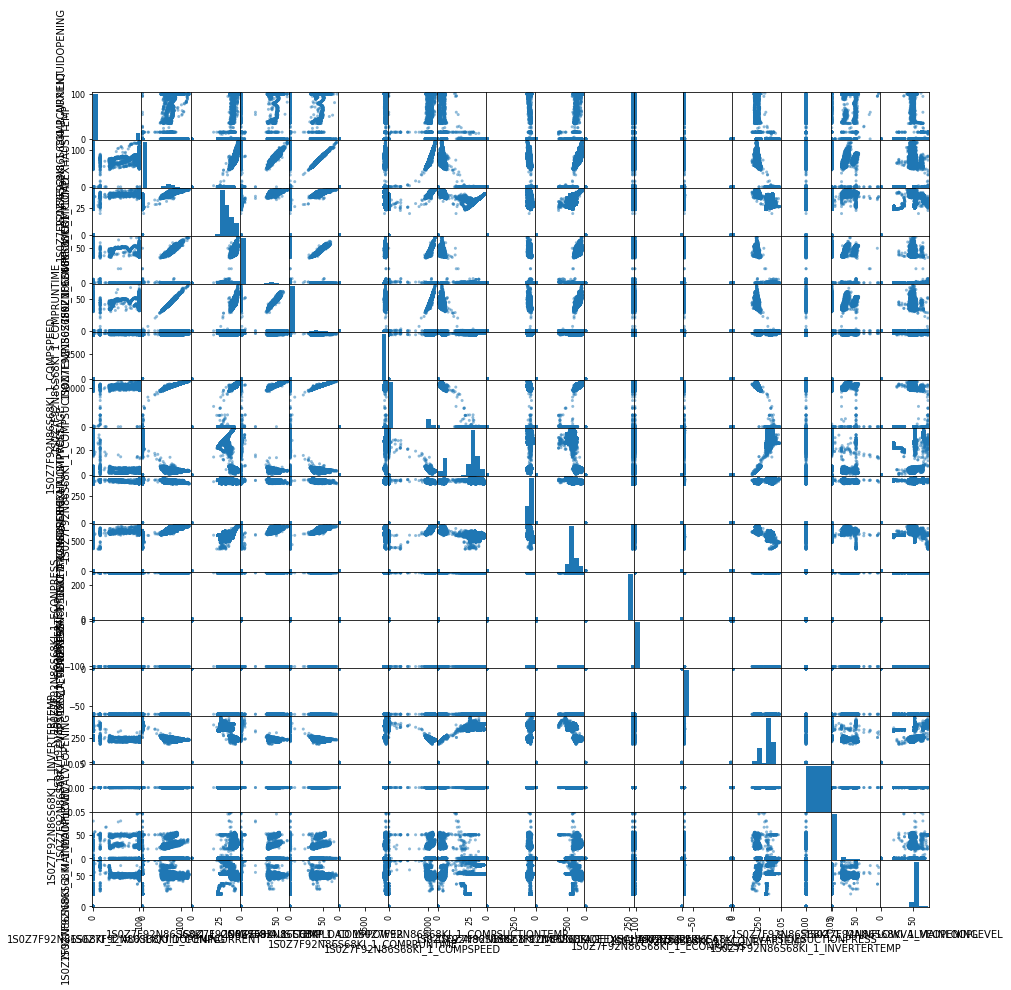

In [14]:
#设备子机 1：
df_scatter_one = df[[
'1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_1_COMPCURRENT',
'1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_1_COMPLOAD',
'1S0Z7F92N86S68KI_1_COMPPOWER',
'1S0Z7F92N86S68KI_1_COMPRUNTIME',
'1S0Z7F92N86S68KI_1_COMPSPEED',
'1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_1_COMPVOLTAGE',
'1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_1_ECONPRESS',
'1S0Z7F92N86S68KI_1_ECONREFRTEMP',
'1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_1_INVERTERTEMP',
'1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_1_MAINLOOPLEVEL',
]]

# 显示汇总统计数据
display(df_scatter_one.describe())

# 为每个数值特征构建直方图
%matplotlib inline
hist = df_scatter_one.hist(bins=30, sharey=True, figsize=(15, 15))

#探索属性之间的成对关系，以了解它们之间的关系
pd.plotting.scatter_matrix(df_scatter_one,  figsize=(15, 15))
plt.show()


#### (3)第二个设备子机 - 相关性探索后，缩小的特征值范围
字段有'1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_2_COMPCURRENT',
'1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_2_COMPLOAD',
'1S0Z7F92N86S68KI_2_COMPPOWER',
'1S0Z7F92N86S68KI_2_COMPRUNTIME',
'1S0Z7F92N86S68KI_2_COMPSPEED',
'1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_2_COMPVOLTAGE',
'1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_2_ECONPRESS',
'1S0Z7F92N86S68KI_2_ECONREFRTEMP',
'1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_2_INVERTERTEMP',
'1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_2_MAINLOOPLEVEL'

#### 其他设备子机同理类推

,1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_2_COMPCURRENT,1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_2_COMPLOAD,1S0Z7F92N86S68KI_2_COMPPOWER,1S0Z7F92N86S68KI_2_COMPRUNTIME,1S0Z7F92N86S68KI_2_COMPSPEED,1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_2_COMPVOLTAGE,1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS,1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT,1S0Z7F92N86S68KI_2_ECONPRESS,1S0Z7F92N86S68KI_2_ECONREFRTEMP,1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS,1S0Z7F92N86S68KI_2_INVERTERTEMP,1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING,1S0Z7F92N86S68KI_2_MAINLOOPLEVEL
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.0,99999.000000,99999.000000
mean,5.046440,4.690787,31.291338,0.308953,0.318013,4415.681317,1162.843048,28.814108,397.826088,545.991824,-256.882135,-101.287844,-61.401936,359.071604,0.0,0.199982,71.516155
std,21.867895,20.654599,3.158602,4.229487,4.403468,48.760242,4913.785450,6.405105,12.870768,69.590831,19.793984,1.109630,0.674646,33.553080,0.0,2.483149,6.156351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-352.600000,-101.300000,-61.600000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,29.000000,0.000000,0.000000,4415.000000,0.000000,28.000000,387.000000,487.900000,-257.200000,-101.300000,-61.400000,354.000000,0.0,0.000000,72.000000
50%,0.000000,0.000000,30.600000,0.000000,0.000000,4415.000000,0.000000,29.600000,402.000000,555.800000,-252.600000,-101.300000,-61.400000,363.000000,0.0,0.000000,73.000000
75%,0.000000,0.000000,33.300000,0.000000,0.000000,4415.000000,0.000000,31.900000,406.000000,593.700000,-249.200000,-101.300000,-61.400000,375.500000,0.0,0.000000,75.000000
max,100.000000,149.000000,44.400000,84.000000,91.000000,4478.000000,25644.000000,37.300000,435.000000,752.000000,0.000000,0.000000,0.000000,451.000000,0.0,63.000000,75.000000


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


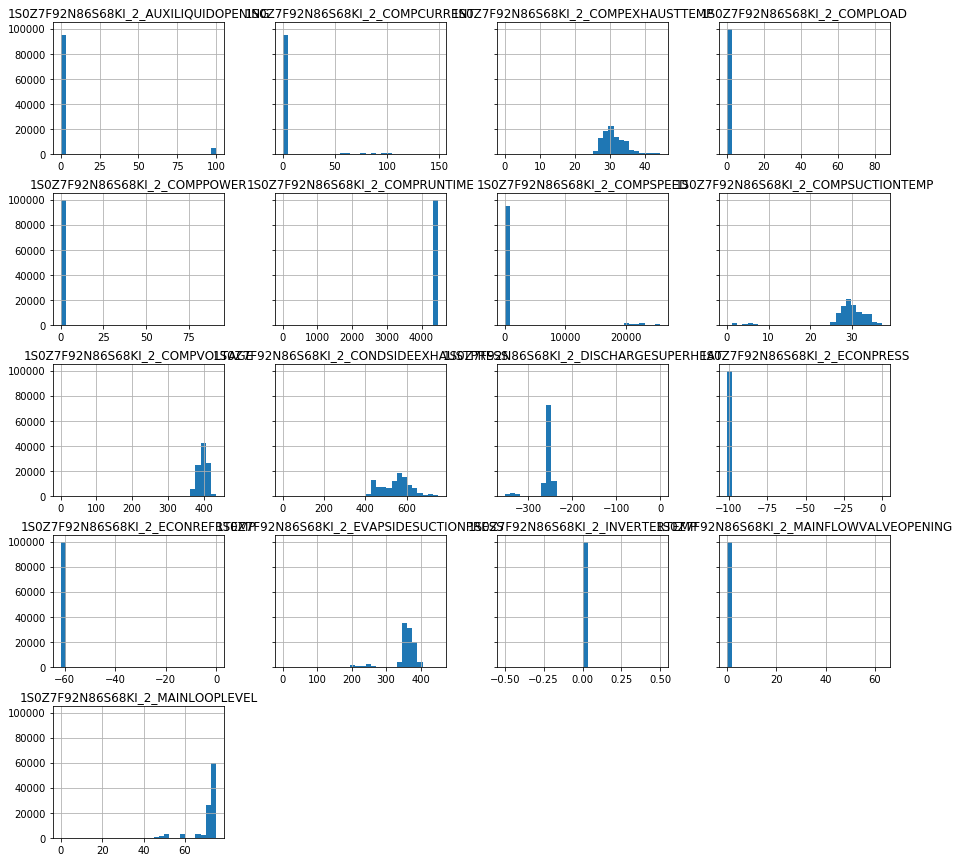

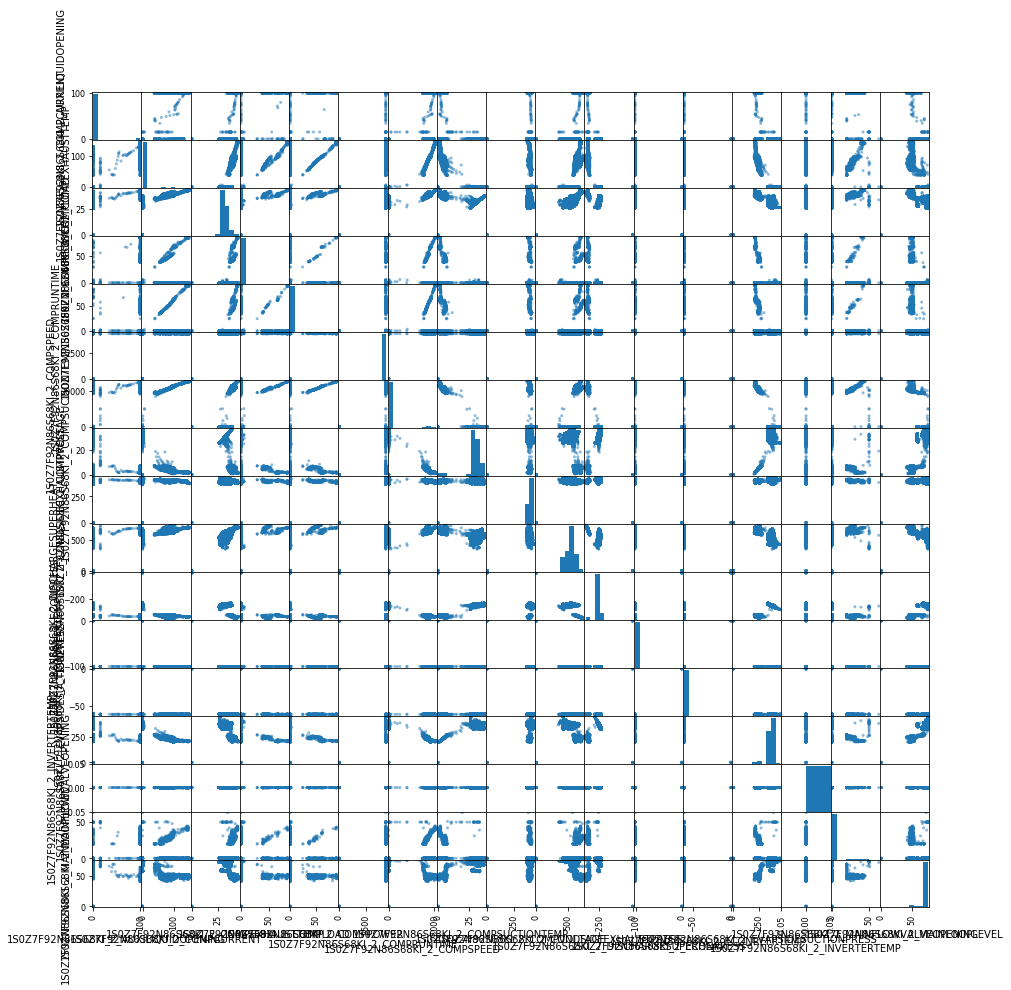

In [15]:
#设备子机 2：
df_scatter_two = df[[
'1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_2_COMPCURRENT',
'1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_2_COMPLOAD',
'1S0Z7F92N86S68KI_2_COMPPOWER',
'1S0Z7F92N86S68KI_2_COMPRUNTIME',
'1S0Z7F92N86S68KI_2_COMPSPEED',
'1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_2_COMPVOLTAGE',
'1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_2_ECONPRESS',
'1S0Z7F92N86S68KI_2_ECONREFRTEMP',
'1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_2_INVERTERTEMP',
'1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_2_MAINLOOPLEVEL'
]]

# 显示汇总统计数据
display(df_scatter_two.describe())

# 为每个数值特征构建直方图
%matplotlib inline
hist = df_scatter_two.hist(bins=30, sharey=True, figsize=(15, 15))

#探索属性之间的成对关系，以了解它们之间的关系
pd.plotting.scatter_matrix(df_scatter_two,  figsize=(15, 15))
plt.show()


### 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。

使用相同的 pandas  crosstab() 和 hist() 函数

1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING


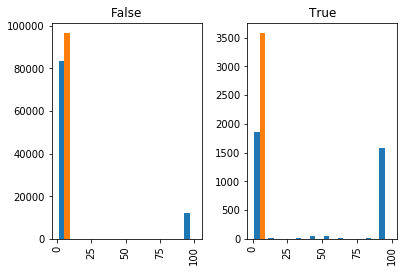

1S0Z7F92N86S68KI_1_COMPCURRENT


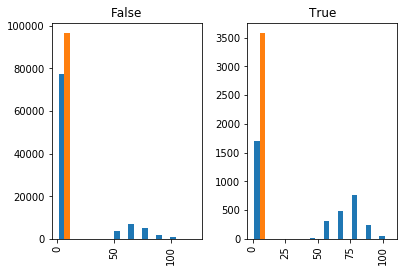

1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP


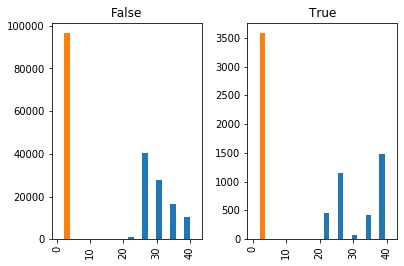

1S0Z7F92N86S68KI_1_COMPLOAD


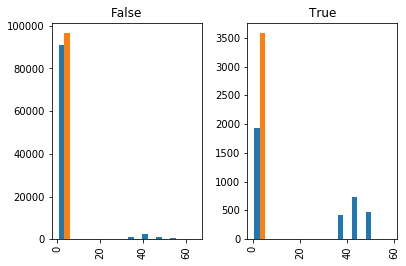

1S0Z7F92N86S68KI_1_COMPPOWER


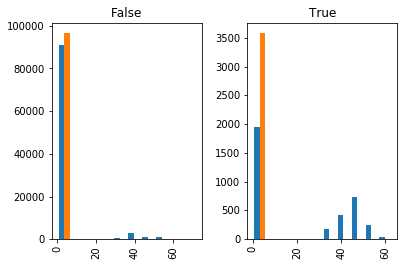

1S0Z7F92N86S68KI_1_COMPRUNTIME


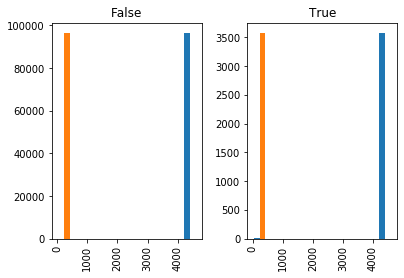

1S0Z7F92N86S68KI_1_COMPSPEED


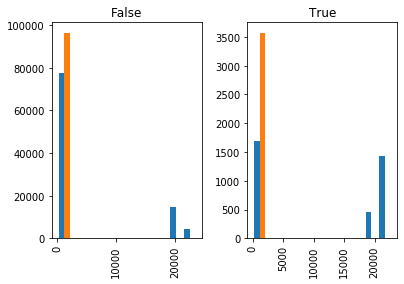

1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP


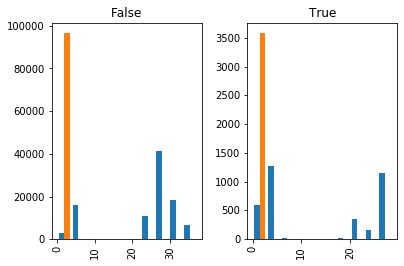

1S0Z7F92N86S68KI_1_COMPVOLTAGE


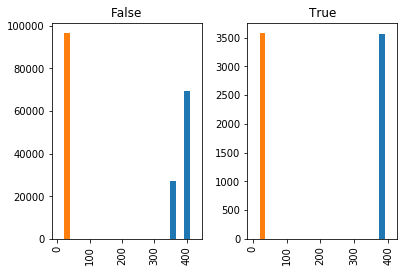

1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS


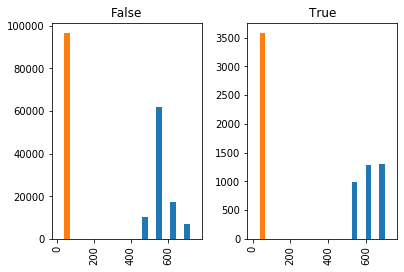

1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT


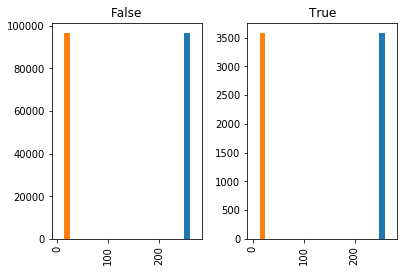

1S0Z7F92N86S68KI_1_ECONPRESS


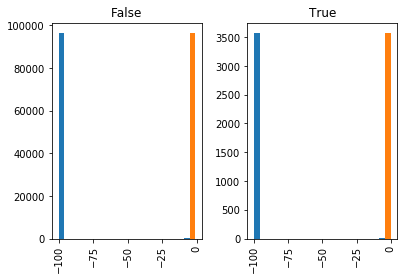

1S0Z7F92N86S68KI_1_ECONREFRTEMP


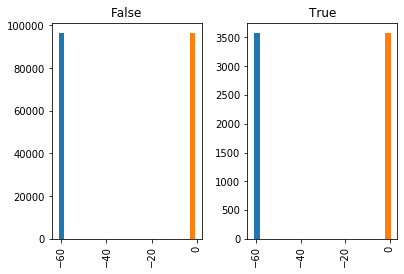

1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS


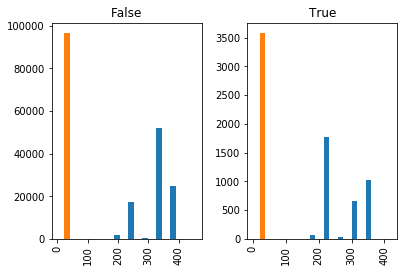

1S0Z7F92N86S68KI_1_INVERTERTEMP


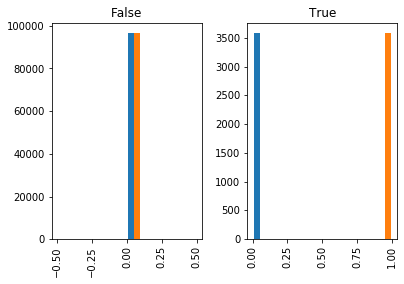

1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING


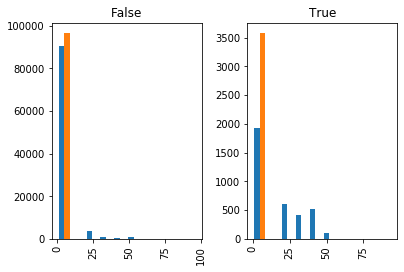

1S0Z7F92N86S68KI_1_MAINLOOPLEVEL


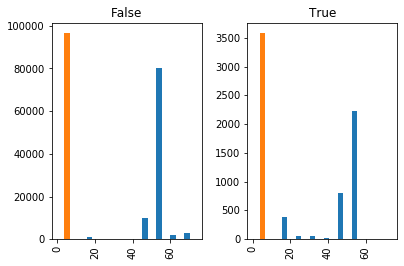

1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING


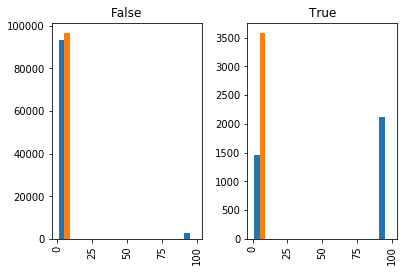

1S0Z7F92N86S68KI_2_COMPCURRENT


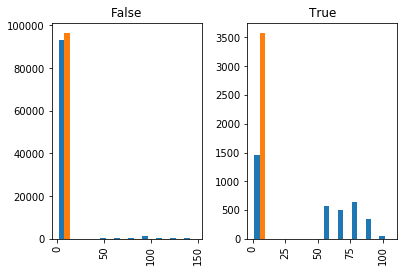

1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP


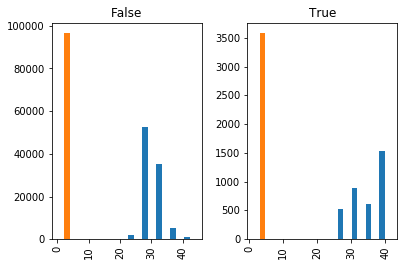

1S0Z7F92N86S68KI_2_COMPLOAD


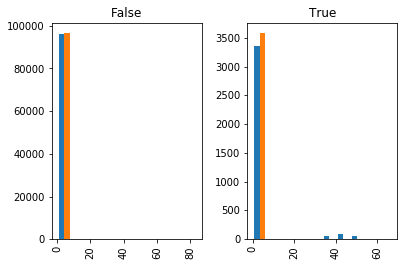

1S0Z7F92N86S68KI_2_COMPPOWER


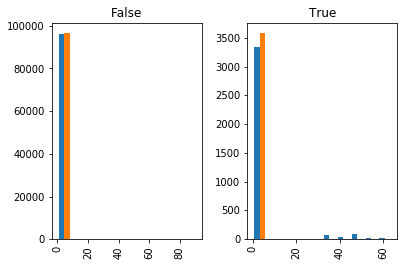

1S0Z7F92N86S68KI_2_COMPRUNTIME


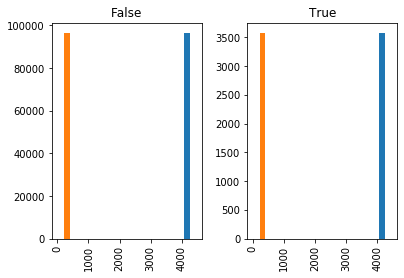

1S0Z7F92N86S68KI_2_COMPSPEED


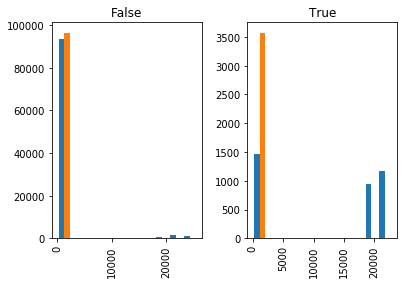

1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP


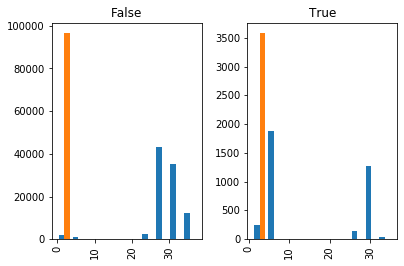

1S0Z7F92N86S68KI_2_COMPVOLTAGE


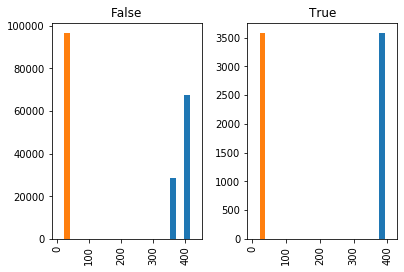

1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS


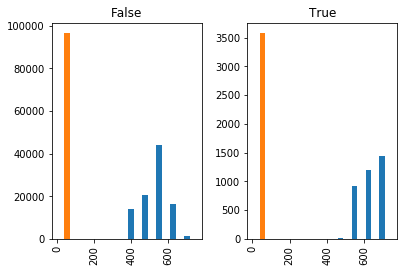

1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT


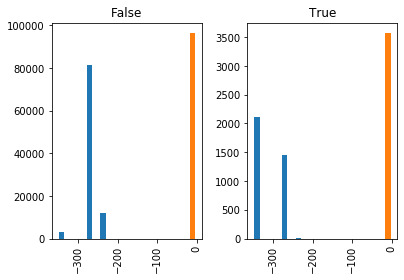

1S0Z7F92N86S68KI_2_ECONPRESS


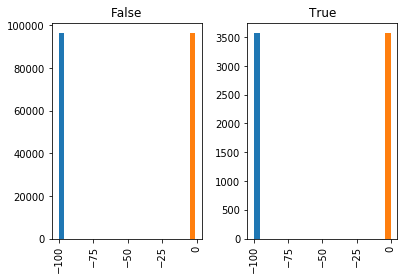

1S0Z7F92N86S68KI_2_ECONREFRTEMP


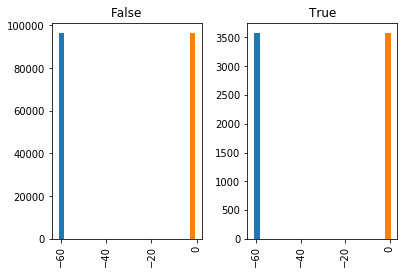

1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS


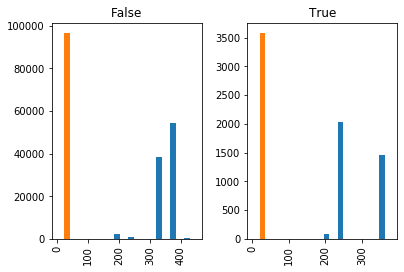

1S0Z7F92N86S68KI_2_INVERTERTEMP


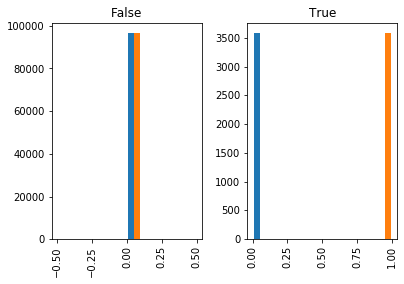

1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING


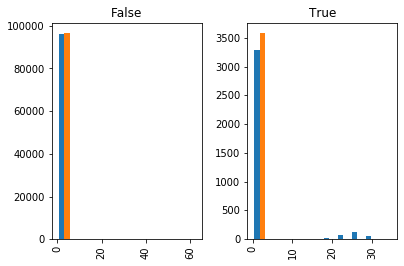

1S0Z7F92N86S68KI_2_MAINLOOPLEVEL


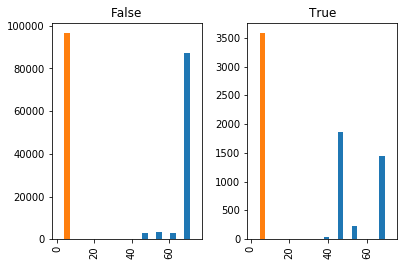

1S0Z7F92N86S68KI_3_AUXILIQUIDOPENING


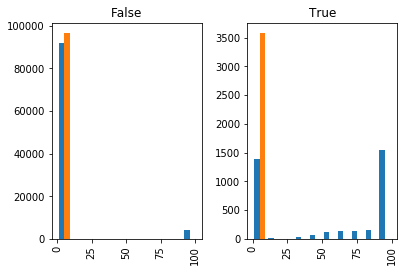

1S0Z7F92N86S68KI_3_COMPCURRENT


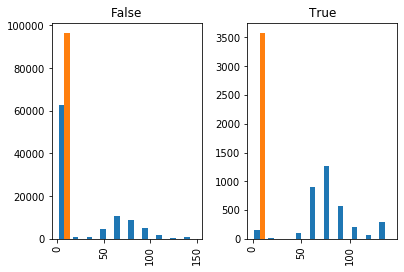

1S0Z7F92N86S68KI_3_COMPEXHAUSTTEMP


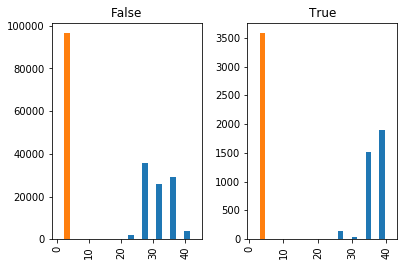

1S0Z7F92N86S68KI_3_COMPLOAD


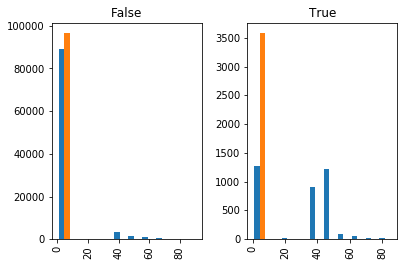

1S0Z7F92N86S68KI_3_COMPPOWER


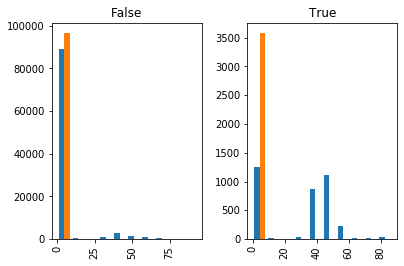

1S0Z7F92N86S68KI_3_COMPRUNTIME


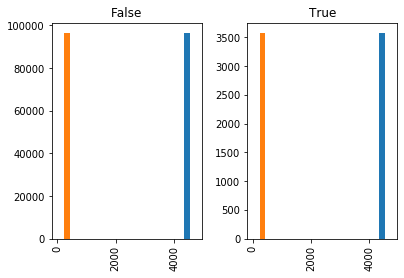

1S0Z7F92N86S68KI_3_COMPSPEED


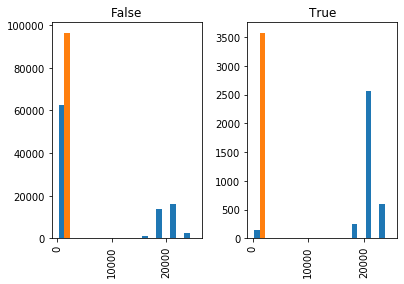

1S0Z7F92N86S68KI_3_COMPSUCTIONTEMP


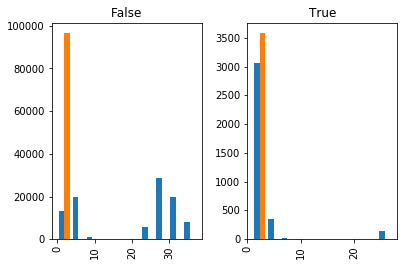

1S0Z7F92N86S68KI_3_COMPVOLTAGE


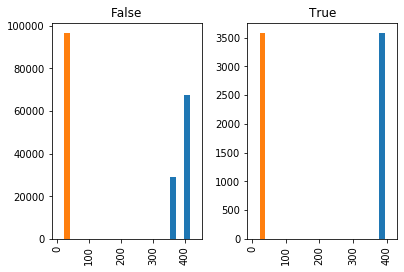

1S0Z7F92N86S68KI_3_CONDSIDEEXHAUSTPRESS


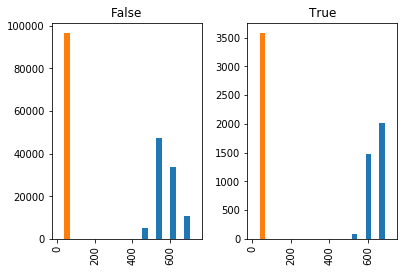

1S0Z7F92N86S68KI_3_DISCHARGESUPERHEAT


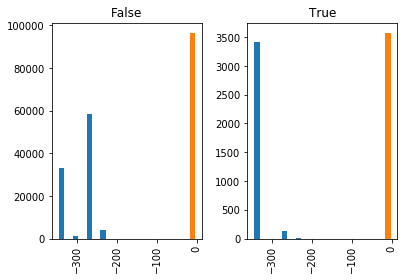

1S0Z7F92N86S68KI_3_ECONPRESS


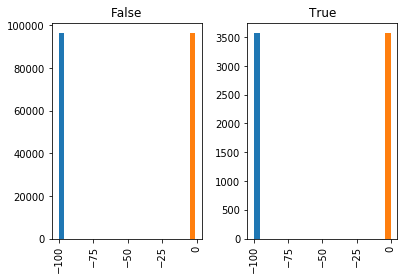

1S0Z7F92N86S68KI_3_ECONREFRTEMP


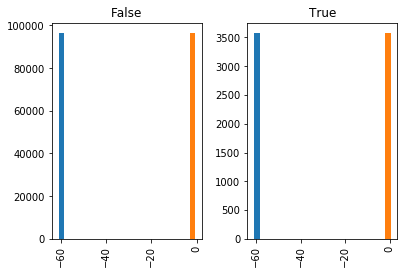

1S0Z7F92N86S68KI_3_EVAPSIDESUCTIONPRESS


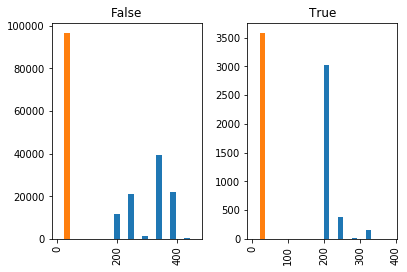

1S0Z7F92N86S68KI_3_INVERTERTEMP


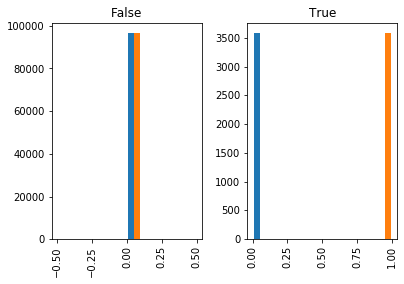

1S0Z7F92N86S68KI_3_MAINFLOWVALVEOPENING


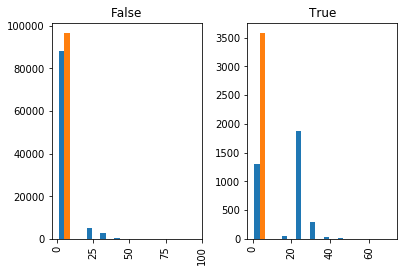

1S0Z7F92N86S68KI_3_MAINLOOPLEVEL


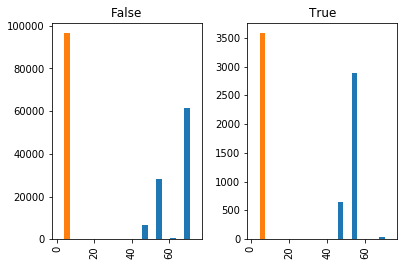

SYSTEM_CONDCAPACITY


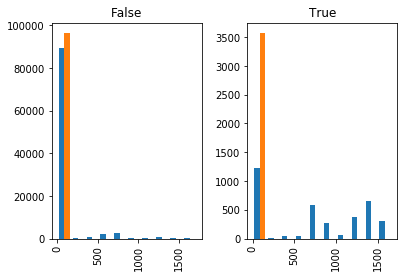

SYSTEM_CONDSIDETEMPIN


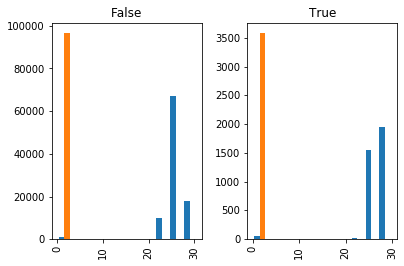

SYSTEM_CONDSIDETEMPOUT


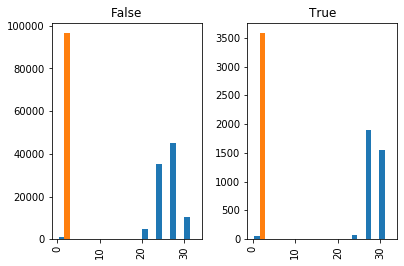

SYSTEM_EVAPCAPACITY


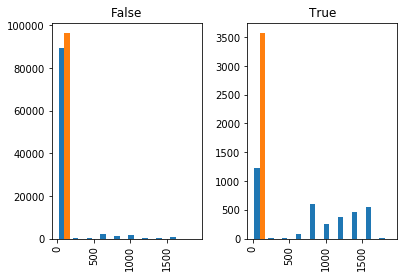

SYSTEM_EVAPSIDETEMPOUT


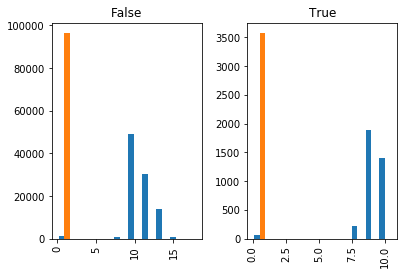

SYSTEM_UNITPOWER


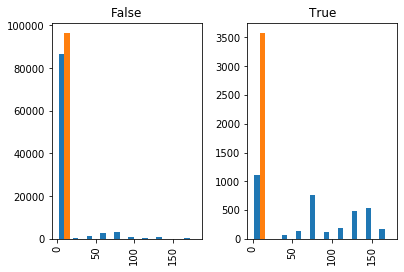

hascode


In [16]:
df_final = df[[
'1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_1_COMPCURRENT',
'1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_1_COMPLOAD',
'1S0Z7F92N86S68KI_1_COMPPOWER',
'1S0Z7F92N86S68KI_1_COMPRUNTIME',
'1S0Z7F92N86S68KI_1_COMPSPEED',
'1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_1_COMPVOLTAGE',
'1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_1_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_1_ECONPRESS',
'1S0Z7F92N86S68KI_1_ECONREFRTEMP',
'1S0Z7F92N86S68KI_1_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_1_INVERTERTEMP',
'1S0Z7F92N86S68KI_1_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_1_MAINLOOPLEVEL',
'1S0Z7F92N86S68KI_2_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_2_COMPCURRENT',
'1S0Z7F92N86S68KI_2_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_2_COMPLOAD',
'1S0Z7F92N86S68KI_2_COMPPOWER',
'1S0Z7F92N86S68KI_2_COMPRUNTIME',
'1S0Z7F92N86S68KI_2_COMPSPEED',
'1S0Z7F92N86S68KI_2_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_2_COMPVOLTAGE',
'1S0Z7F92N86S68KI_2_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_2_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_2_ECONPRESS',
'1S0Z7F92N86S68KI_2_ECONREFRTEMP',
'1S0Z7F92N86S68KI_2_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_2_INVERTERTEMP',
'1S0Z7F92N86S68KI_2_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_2_MAINLOOPLEVEL',
'1S0Z7F92N86S68KI_3_AUXILIQUIDOPENING',
'1S0Z7F92N86S68KI_3_COMPCURRENT',
'1S0Z7F92N86S68KI_3_COMPEXHAUSTTEMP',
'1S0Z7F92N86S68KI_3_COMPLOAD',
'1S0Z7F92N86S68KI_3_COMPPOWER',
'1S0Z7F92N86S68KI_3_COMPRUNTIME',
'1S0Z7F92N86S68KI_3_COMPSPEED',
'1S0Z7F92N86S68KI_3_COMPSUCTIONTEMP',
'1S0Z7F92N86S68KI_3_COMPVOLTAGE',
'1S0Z7F92N86S68KI_3_CONDSIDEEXHAUSTPRESS',
'1S0Z7F92N86S68KI_3_DISCHARGESUPERHEAT',
'1S0Z7F92N86S68KI_3_ECONPRESS',
'1S0Z7F92N86S68KI_3_ECONREFRTEMP',
'1S0Z7F92N86S68KI_3_EVAPSIDESUCTIONPRESS',
'1S0Z7F92N86S68KI_3_INVERTERTEMP',
'1S0Z7F92N86S68KI_3_MAINFLOWVALVEOPENING',
'1S0Z7F92N86S68KI_3_MAINLOOPLEVEL',
'SYSTEM_CONDCAPACITY',
'SYSTEM_CONDSIDETEMPIN',
'SYSTEM_CONDSIDETEMPOUT',
'SYSTEM_EVAPCAPACITY',
'SYSTEM_EVAPSIDETEMPOUT',
'SYSTEM_UNITPOWER',
'hascode'
]]

# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。

for column in df_final.select_dtypes(exclude=['object']).columns:
    print(column)
    if column != 'hascode':
        hist = df_final[[column, 'hascode']].hist(by='hascode', bins=10)
        plt.show()

In [17]:
# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。
display(df_final.corr())

,1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING,1S0Z7F92N86S68KI_1_COMPCURRENT,1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP,1S0Z7F92N86S68KI_1_COMPLOAD,1S0Z7F92N86S68KI_1_COMPPOWER,1S0Z7F92N86S68KI_1_COMPRUNTIME,1S0Z7F92N86S68KI_1_COMPSPEED,1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP,1S0Z7F92N86S68KI_1_COMPVOLTAGE,1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS,...,1S0Z7F92N86S68KI_3_INVERTERTEMP,1S0Z7F92N86S68KI_3_MAINFLOWVALVEOPENING,1S0Z7F92N86S68KI_3_MAINLOOPLEVEL,SYSTEM_CONDCAPACITY,SYSTEM_CONDSIDETEMPIN,SYSTEM_CONDSIDETEMPOUT,SYSTEM_EVAPCAPACITY,SYSTEM_EVAPSIDETEMPOUT,SYSTEM_UNITPOWER,hascode
1S0Z7F92N86S68KI_1_AUXILIQUIDOPENING,1.000000,0.792640,0.672524,0.580660,0.575781,-0.084220,0.802674,-0.779288,-0.213905,0.680141,...,NaN,0.305898,-0.460538,0.477881,0.173733,0.318507,0.476980,-0.324049,0.483301,0.174746
1S0Z7F92N86S68KI_1_COMPCURRENT,0.792640,1.000000,0.808752,0.525811,0.527607,-0.146832,0.988598,-0.954553,-0.281661,0.809957,...,NaN,0.253106,-0.569001,0.384361,0.173658,0.358036,0.379437,-0.375703,0.430263,0.153780
1S0Z7F92N86S68KI_1_COMPEXHAUSTTEMP,0.672524,0.808752,1.000000,0.439439,0.440933,0.054153,0.803365,-0.640025,-0.180837,0.810818,...,NaN,0.172856,-0.337781,0.279814,0.264670,0.382119,0.276174,-0.222489,0.311246,0.089598
1S0Z7F92N86S68KI_1_COMPLOAD,0.580660,0.525811,0.439439,1.000000,0.790399,0.037511,0.538336,-0.534851,-0.108753,0.412517,...,NaN,0.389346,-0.235982,0.776799,0.141763,0.249488,0.773641,-0.221252,0.717980,0.293019
1S0Z7F92N86S68KI_1_COMPPOWER,0.575781,0.527607,0.440933,0.790399,1.000000,0.039151,0.536465,-0.532174,-0.115240,0.416417,...,NaN,0.393321,-0.235349,0.784136,0.144485,0.252678,0.778611,-0.219885,0.726051,0.299608
1S0Z7F92N86S68KI_1_COMPRUNTIME,-0.084220,-0.146832,0.054153,0.037511,0.039151,1.000000,-0.153646,0.216643,0.536536,0.044313,...,NaN,-0.009225,0.337474,0.102162,0.081951,0.014909,0.102499,0.217159,0.053922,-0.009838
1S0Z7F92N86S68KI_1_COMPSPEED,0.802674,0.988598,0.803365,0.538336,0.536465,-0.153646,1.000000,-0.969373,-0.254508,0.795709,...,NaN,0.264395,-0.583788,0.391486,0.158016,0.342217,0.389819,-0.389906,0.431336,0.154277
1S0Z7F92N86S68KI_1_COMPSUCTIONTEMP,-0.779288,-0.954553,-0.640025,-0.534851,-0.532174,0.216643,-0.969373,1.000000,0.258544,-0.712088,...,NaN,-0.286321,0.624084,-0.418025,-0.107318,-0.299805,-0.417446,0.420445,-0.454110,-0.178062
1S0Z7F92N86S68KI_1_COMPVOLTAGE,-0.213905,-0.281661,-0.180837,-0.108753,-0.115240,0.536536,-0.254508,0.258544,1.000000,-0.274497,...,NaN,-0.017831,0.104780,-0.063130,-0.212942,-0.242623,-0.058768,-0.088922,-0.084401,-0.039185
1S0Z7F92N86S68KI_1_CONDSIDEEXHAUSTPRESS,0.680141,0.809957,0.810818,0.412517,0.416417,0.044313,0.795709,-0.712088,-0.274497,1.000000,...,NaN,0.250123,-0.591347,0.312672,0.358680,0.509939,0.307230,-0.306186,0.363474,0.170058


In [18]:
# 相关性探索：看看每个特征与目标变量 `hasCode` 之间的关系。
#pd.plotting.scatter_matrix(df_final, figsize=(20, 20))
#plt.show()

### 完成了本章节的内容，包括：
   - [ ] 1）探索相关性；
   - [ ] 2）缩小特征值范围；
   - [ ] 3）确认数据集从282列缩减为58个列
   